<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Load data](#load_data)
2. [Initial Cleaning](#initial_cleaning)
3. [Price and Quantity Cleaning](#price_and_quantity_cleaning)
4. [Coffee Origin Cleaning](#coffee_origin_cleaning)
5. [Export processed data](#export_data)
6. [External processing](#external_processing)


# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [ ]:
%reload_ext autoreload
%autoreload 2

import json
import sys
from datetime import datetime
from pathlib import Path

import matplotlib as mpl
import numpy as np
import pandas as pd
import pycountry
from unidecode import unidecode

basedir = Path().resolve().parent
if str(basedir) not in sys.path:
    sys.path.insert(0, str(basedir))


pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
mpl.rcParams["figure.dpi"] = 300

https://www.coffeereview.com/review/


# 1. Import raw data <a id='load_data'></a>
[Back to top](#table_of_contents)

In [2]:
# Set up directories
BASE_DIR: Path = Path().resolve().parent
DATA_DIR: Path = BASE_DIR / "data"
FILE_IN: str = "25072024_reviews.csv"

# Load data
df_in: pd.DataFrame = pd.read_csv(DATA_DIR / "raw" / FILE_IN)
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   rating                             7890 non-null   object 
 1   roaster                            7890 non-null   object 
 2   title                              7890 non-null   object 
 3   blind_assessment                   7889 non-null   object 
 4   notes                              7888 non-null   object 
 5   bottom_line                        3812 non-null   object 
 6   roaster location                   7887 non-null   object 
 7   coffee origin                      7386 non-null   object 
 8   roast level                        7488 non-null   object 
 9   agtron                             7890 non-null   object 
 10  est. price                         5852 non-null   object 
 11  review date                        7890 non-null   objec

# 2. Initial Cleaning <a id='initial_cleaning'></a>
[Back to top](#table_of_contents)

First step is basic data checks and cleaning. This includes renaming and combining and creating columns, dropping unecessary columns, setting datatypes, and string cleaning. 

In [3]:
# Cleanup column names
df_in.columns = (
    df_in.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(".", "")
)

df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rating                            7890 non-null   object 
 1   roaster                           7890 non-null   object 
 2   title                             7890 non-null   object 
 3   blind_assessment                  7889 non-null   object 
 4   notes                             7888 non-null   object 
 5   bottom_line                       3812 non-null   object 
 6   roaster_location                  7887 non-null   object 
 7   coffee_origin                     7386 non-null   object 
 8   roast_level                       7488 non-null   object 
 9   agtron                            7890 non-null   object 
 10  est_price                         5852 non-null   object 
 11  review_date                       7890 non-null   object 
 12  aroma 

In [ ]:
def tweak_df(df: pd.DataFrame) -> pd.DataFrame:
    """Initial data cleaning"""
    return (
        df.assign(
            review_date=lambda df_: pd.to_datetime(df_["review_date"], format="%B %Y"),
            # Combing acidity and acidity/structure into one column, they are the same
            # field but names used in reviews changed at one point
            acidity=lambda df_: df_["acidity"].fillna(df_["acidity/structure"]),
            # Split the agtron column into one for external bean agtron data and ground
            # bean agtron data
            agtron_external=lambda df_: pd.to_numeric(
                df_["agtron"].str.split("/", expand=True)[0].str.strip(),
                errors="coerce",
            ),
            agtron_ground=lambda df_: pd.to_numeric(
                df_["agtron"].str.split("/", expand=True)[1].str.strip(),
                errors="coerce",
            ),
            # Distinguish espresso roasts from other reviews
            is_espresso=lambda df_: df_.apply(
                lambda row: (
                    True
                    if "espresso" in row["title"].lower()
                    or pd.notnull(row["with_milk"])
                    else False
                ),
                axis=1,
            ),
        )
        .replace(["", "NR", "N/A", "na"], np.nan)
        # Agtron values must be equalt to or below 100,
        # some entries on website have typos
        .loc[
            lambda df_: (df_["agtron_external"] <= 100) & (df_["agtron_ground"] <= 100),
            :,
        ]
        # Run str.strip on every string column
        .map(lambda x: x.strip() if isinstance(x, str) else x)
        .drop(
            columns=["acidity/structure", "agtron", "refresh(enable_javascript_first)"]
        )
        .astype(
            {
                k: "float"
                for k in [
                    "agtron_external",
                    "agtron_ground",
                    "acidity",
                    "rating",
                    "aroma",
                    "body",
                    "flavor",
                    "aftertaste",
                ]
            }
        )
    )


df: pd.DataFrame = tweak_df(df_in)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7566 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rating            7563 non-null   float64       
 1   roaster           7566 non-null   object        
 2   title             7566 non-null   object        
 3   blind_assessment  7566 non-null   object        
 4   notes             7565 non-null   object        
 5   bottom_line       3758 non-null   object        
 6   roaster_location  7564 non-null   object        
 7   coffee_origin     7299 non-null   object        
 8   roast_level       7445 non-null   object        
 9   est_price         5790 non-null   object        
 10  review_date       7566 non-null   datetime64[ns]
 11  aroma             7540 non-null   float64       
 12  acidity           6322 non-null   float64       
 13  body              7556 non-null   float64       
 14  flavor            7553 non-nu

# 3. Price and Quantity Cleaning <a id='price_and_quantity_cleaning'></a>
[Back to top](#table_of_contents)

The `est_price` column contains information on coffe roast price, quantity, and currency. We split this column to separate price and quantity information. Splitting on "/" creates one column with the price and currency and another with the quantity and unit of measure. Quantities need to be standardized to a single representation for each unit. We also filter out all products that came in units of cans, boxes, capusles, pods, etc. We will ignore extra-processed coffee and only concern ourselves with coffee sold in bags or bulk, whether ground or whole.

### Cleaning quantities

In [ ]:
# Defining list of quantity terms to drop from the dataset
drop_terms: list[str] = [
    "can",
    "box",
    "capsules",
    "K-",
    "cups",
    "bags",
    "concentrate",
    "discs",
    "bottle",
    "pods",
    "ml",
    "pods",
    "pouch",
    "packet|tin",
    "instant",
    "sachet",
    "vue",
    "single-serve",
    "fluid",
    "capsultes",
]

# Build a regex string to match any of the drop terms
drop_terms_string: str = "|".join(drop_terms)


def price_quantity_split(df: pd.DataFrame) -> pd.DataFrame:
    """Split the est_price column into price and quantity columns"""
    price_quantity = (
        df
        # Split est_price into columns for price and quantity
        .est_price.str.split("/", n=1, expand=True)
        # Remove any commas from the price and quantity columns
        .replace(",", "", regex=True)
        .rename(columns={0: "price", 1: "quantity"})
        .assign(
            # Cleanup quantity
            quantity=lambda df_: (
                df_["quantity"]
                .str.lower()
                .str.strip()
                # Remove parentheses and anything inside them
                .str.replace(r"\(.*?\)", "", regex=True)
                # Remove anything after a semicolon. This is usually a note,
                # or deal price.
                .str.replace(r";.*", "", regex=True)
                # Standardize units
                .str.replace(r".g$", " grams", regex=True)
                .str.replace(r"\sg$", "grams", regex=True)
                .str.replace(r"\bgram$", "grams", regex=True)
                .str.replace(r"pound$", "1 pounds", regex=True)
                .str.replace(r"oz|onces|ouncues|ounce$|ounces\*", "ounces", regex=True)
                .str.replace("kilogram", "kilograms")
                .str.replace("kg", "kilograms")
                # Remove "online" from any quantity
                .str.replace("online", "")
                .str.strip()
            ),
            price=lambda df_: df_["price"].str.replace("..", "."),
        )
        .dropna()
        # Remove rows where coffee is sold in a can, box, pouch, packet, or tin
        .loc[
            lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),
            :,
        ]
        # Split quantity into value and unit, and split price into value and currency
        .assign(
            # Extract number value from quantity
            quantity_value=lambda df_: (
                df_["quantity"].str.extract(r"(\d+)").astype(float)
            ),
            # Extract the unit from quantity column
            quantity_unit=lambda df_: (
                df_["quantity"]
                .str.replace(r"(\d+)", "", regex=True)
                .replace(r"\.", "", regex=True)
                .str.strip()
                .mask(lambda s: s == "g", "grams")
                .mask(lambda s: s == "kilo", "kilograms")
                .str.strip()
            ),
            # Extract price value from price column
            price_value=lambda df_: (
                df_["price"].str.extract(r"(\d+\.\d+|\d+)").astype(float)
            ),
            # Extract currency from price column
            price_currency=lambda df_: (
                df_["price"]
                .str.replace(",", "")
                .str.replace(r"(\d+\.\d+|\d+)", "", regex=True)
                .str.strip()
            ),
        )
        # Drop the original price and quantity columns
        .drop(columns=["price", "quantity"])
        # Remove rows where quantity_unit contains
        .loc[lambda df_: ~df_["quantity_unit"].str.contains(r"\(", regex=True), :]
    )
    print(f"Shape of original DataFrame: {df.shape}")
    print(f"Shape of price_quantity: {price_quantity.shape}")

    # Merge the price_quantity DataFrame with the original DataFrame
    return df.merge(price_quantity, how="left", left_index=True, right_index=True)


df = df_in.pipe(tweak_df).pipe(price_quantity_split)

df.quantity_unit.value_counts()

Shape of original DataFrame: (7566, 21)
Shape of price_quantity: (5607, 4)


quantity_unit
ounces       4757
grams         824
pounds         17
kilograms       9
Name: count, dtype: int64

In [6]:
def convert_to_lbs(df: pd.DataFrame) -> pd.DataFrame:
    """Create a new column with the quantity in pounds"""
    to_lbs_conversion: dict[str, float] = {
        "ounces": 1 / 16,
        "pounds": 1,
        "kilograms": 2.20462,
        "grams": 0.00220462,
    }

    df["quantity_in_lbs"] = np.round(
        df["quantity_value"] * df["quantity_unit"].map(to_lbs_conversion), 2
    )
    return df


df = df_in.pipe(tweak_df).pipe(price_quantity_split).pipe(convert_to_lbs)

df.groupby("quantity_unit")[
    ["est_price", "quantity_value", "quantity_unit", "quantity_in_lbs"]
].sample(1)

Shape of original DataFrame: (7566, 21)
Shape of price_quantity: (5607, 4)


,est_price,quantity_value,quantity_unit,quantity_in_lbs
1881,HK $125.00/250 grams,250.0,grams,0.55
174,CAD $37.46/1 kg. (2.2 lbs.),1.0,kilograms,2.20
2110,$39.95/8 ounces,8.0,ounces,0.50
2241,$18.99/2 pounds,2.0,pounds,2.00


### Cleaning Prices and Currencies
Here we normalize the currency column to contain a standard set of ISO 4217 currency codes. This will help us with fetching exchange rates from an API later on.

In [7]:
def clean_currency(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize currencies to ISO 4217 codes."""
    price_currency = (
        df.price_currency.str.upper()
        .str.replace(r"^\$$", "USD", regex=True)
        .str.replace("PRICE: $", "USD")
        .str.replace("$", "")
        .str.replace("#", "GBP")
        .str.replace("¥", "JPY")
        .str.replace("£", "GBP")
        .str.replace("€", "EUR")
        .str.replace("POUND", "GBP")
        .str.replace("PESOS", "MXN")
        .str.replace("RMB", "CNY")
        .str.replace("EUROS", "EUR")
        .str.replace("RM", "MYR")
        .str.strip()
        .mask(lambda s: s == "US", "USD")
        .mask(lambda s: s == " ", "USD")
        .mask(lambda s: s == "E", "EUR")
        .mask(lambda s: s == "NTD", "TWD")
        .mask(lambda s: s == "NT", "TWD")
        .mask(lambda s: s == "", "USD")
        .mask(lambda s: s == "HK", "HKD")
        .str.strip()
    )
    return df.assign(price_currency=price_currency)


df = df_in.pipe(tweak_df).pipe(price_quantity_split).pipe(clean_currency)


# Check that currencies make sense from original est_price column
df.loc[:, ["est_price", "price_currency", "price_value"]].groupby(
    "price_currency"
).sample(3, replace=True)

Shape of original DataFrame: (7566, 21)
Shape of price_quantity: (5607, 4)


,est_price,price_currency,price_value
7560,AED $99.75/250 grams,AED,99.75
1462,AED $103.95/250 grams,AED,103.95
1462,AED $103.95/250 grams,AED,103.95
6014,AUD $23.00/400 grams,AUD,23.00
4858,AUD $24.00/300 grams,AUD,24.00
6237,AUD $18.00/250 grams,AUD,18.00
5179,CAD $11.50 / 16 oz.,CAD,11.50
4766,CAD $9.95/12 ounces,CAD,9.95
4968,CAD $11.49/12 ounces,CAD,11.49
3875,RMB $75.00/150 grams,CNY,75.00


In [8]:
df.price_currency.value_counts()

price_currency
USD    4249
TWD    1067
CAD     125
HKD      46
CNY      27
THB      21
KRW      20
JPY      12
GBP      10
AUD      10
EUR       6
AED       5
MYR       3
IDR       3
GTQ       1
MXN       1
LAK       1
Name: count, dtype: int64

#### Converting prices to 2024 USD
Using historical exchange rates we will convert all prices to USD. We then adjust prices from historical USD to 2024 USD using the BLS consumer price index.

In [9]:
with open(DATA_DIR / "external/openex_exchange_rates.json") as f:
    currency_codes: dict[str, dict[str, float]] = dict(json.load(f))


def convert_row(row: pd.Series) -> float | np.float_:
    try:
        date: str = str(row.review_date.strftime("%Y-%m-%d"))
        currency: str = str(row.price_currency)
        value: float | np.float_ = np.round(
            row.price_value / currency_codes[date][currency], 2
        )
    except KeyError:
        value = np.nan
    return value


def convert_currency(df: pd.DataFrame) -> pd.DataFrame:
    df["price_usd"] = df.apply(convert_row, axis=1)
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(price_quantity_split)
    .pipe(clean_currency)
    .pipe(convert_currency)
)


df.groupby("price_currency")[
    [
        "price_usd",
        "price_value",
        "price_currency",
    ]
].sample(1)

Shape of original DataFrame: (7566, 21)
Shape of price_quantity: (5607, 4)


,price_usd,price_value,price_currency
5999,27.16,99.75,AED
6014,16.68,23.00,AUD
1786,15.64,15.99,CAD
1145,37.85,234.00,CNY
4617,15.72,11.90,EUR
6452,30.37,23.90,GBP
1575,12.53,100.00,GTQ
1045,15.19,118.00,HKD
5002,8.52,120000.00,IDR
2443,0.77,88.00,JPY


In [ ]:
def load_cpi_dataframe(file_path: Path) -> pd.DataFrame:
    """Loads and transforms the CPI data."""
    try:
        cpi: pd.DataFrame = pd.read_csv(file_path)
    except FileNotFoundError as exc:
        raise FileNotFoundError(
            "CPI file is not found in the specified directory."
        ) from exc

    cpi.columns = cpi.columns.str.strip().str.lower().str.replace(" ", "_")
    return (
        cpi.drop(columns=["half1", "half2"])
        .melt(id_vars="year", var_name="month", value_name="cpi")
        .assign(
            month=lambda df_: df_["month"].apply(
                lambda x: datetime.strptime(x, "%b").month
            ),
            date=lambda df_: pd.to_datetime(df_[["year", "month"]].assign(day=1)),
        )
        .drop(columns=["year", "month"])
    )


def adjust_row(row: pd.Series, cpi_baseline: float) -> float:
    # CPI is NaN for the current month, return the original price_usd
    if pd.isnull(row["cpi"]):
        return row["price_usd"]
    else:
        return np.round(row["price_usd"] * (cpi_baseline / row["cpi"]), 2)


def create_cpi_adjusted_price(
    df: pd.DataFrame, file_path: Path, date: str = "2024-06-01"
) -> pd.DataFrame:
    """
    Adjusts historical price data to 2024 prices using CPI data.
    """
    cpi: pd.DataFrame = load_cpi_dataframe(file_path)
    cpi_baseline: float = cpi.loc[cpi["date"] == date, "cpi"].values[0]

    return df.merge(cpi, how="left", left_on="review_date", right_on="date").assign(
        price_usd_adj=lambda df_: df_.apply(
            adjust_row, cpi_baseline=cpi_baseline, axis=1
        )
    )


cpi_path: Path = DATA_DIR / "external" / "consumer_price_index.csv"

df = (
    df_in.pipe(tweak_df)
    .pipe(price_quantity_split)
    .pipe(convert_to_lbs)
    .pipe(clean_currency)
    .pipe(convert_currency)
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)
)

df.groupby("price_currency")[
    [
        "price_value",
        "price_currency",
        "price_usd",
        "review_date",
        "price_usd_adj",
    ]
].sample(1)

Shape of original DataFrame: (7566, 21)
Shape of price_quantity: (5607, 4)


,price_value,price_currency,price_usd,review_date,price_usd_adj
5758,99.75,AED,27.16,2019-09-01,33.23
5987,18.00,AUD,13.05,2016-06-01,17.01
4175,29.00,CAD,22.57,2018-05-01,28.18
813,80.00,CNY,11.62,2016-12-01,15.12
6294,50.00,EUR,67.95,2013-12-01,91.60
5158,11.15,GBP,13.67,2022-12-01,14.47
1513,100.00,GTQ,12.53,2013-09-01,16.81
2274,95.00,HKD,12.14,2023-11-01,12.42
4797,120000.00,IDR,8.52,2019-12-01,10.42
3253,1280.00,JPY,11.71,2021-05-01,13.67


<Axes: title={'center': '% Price difference between adjusted and historical prices'}, xlabel='review_date'>

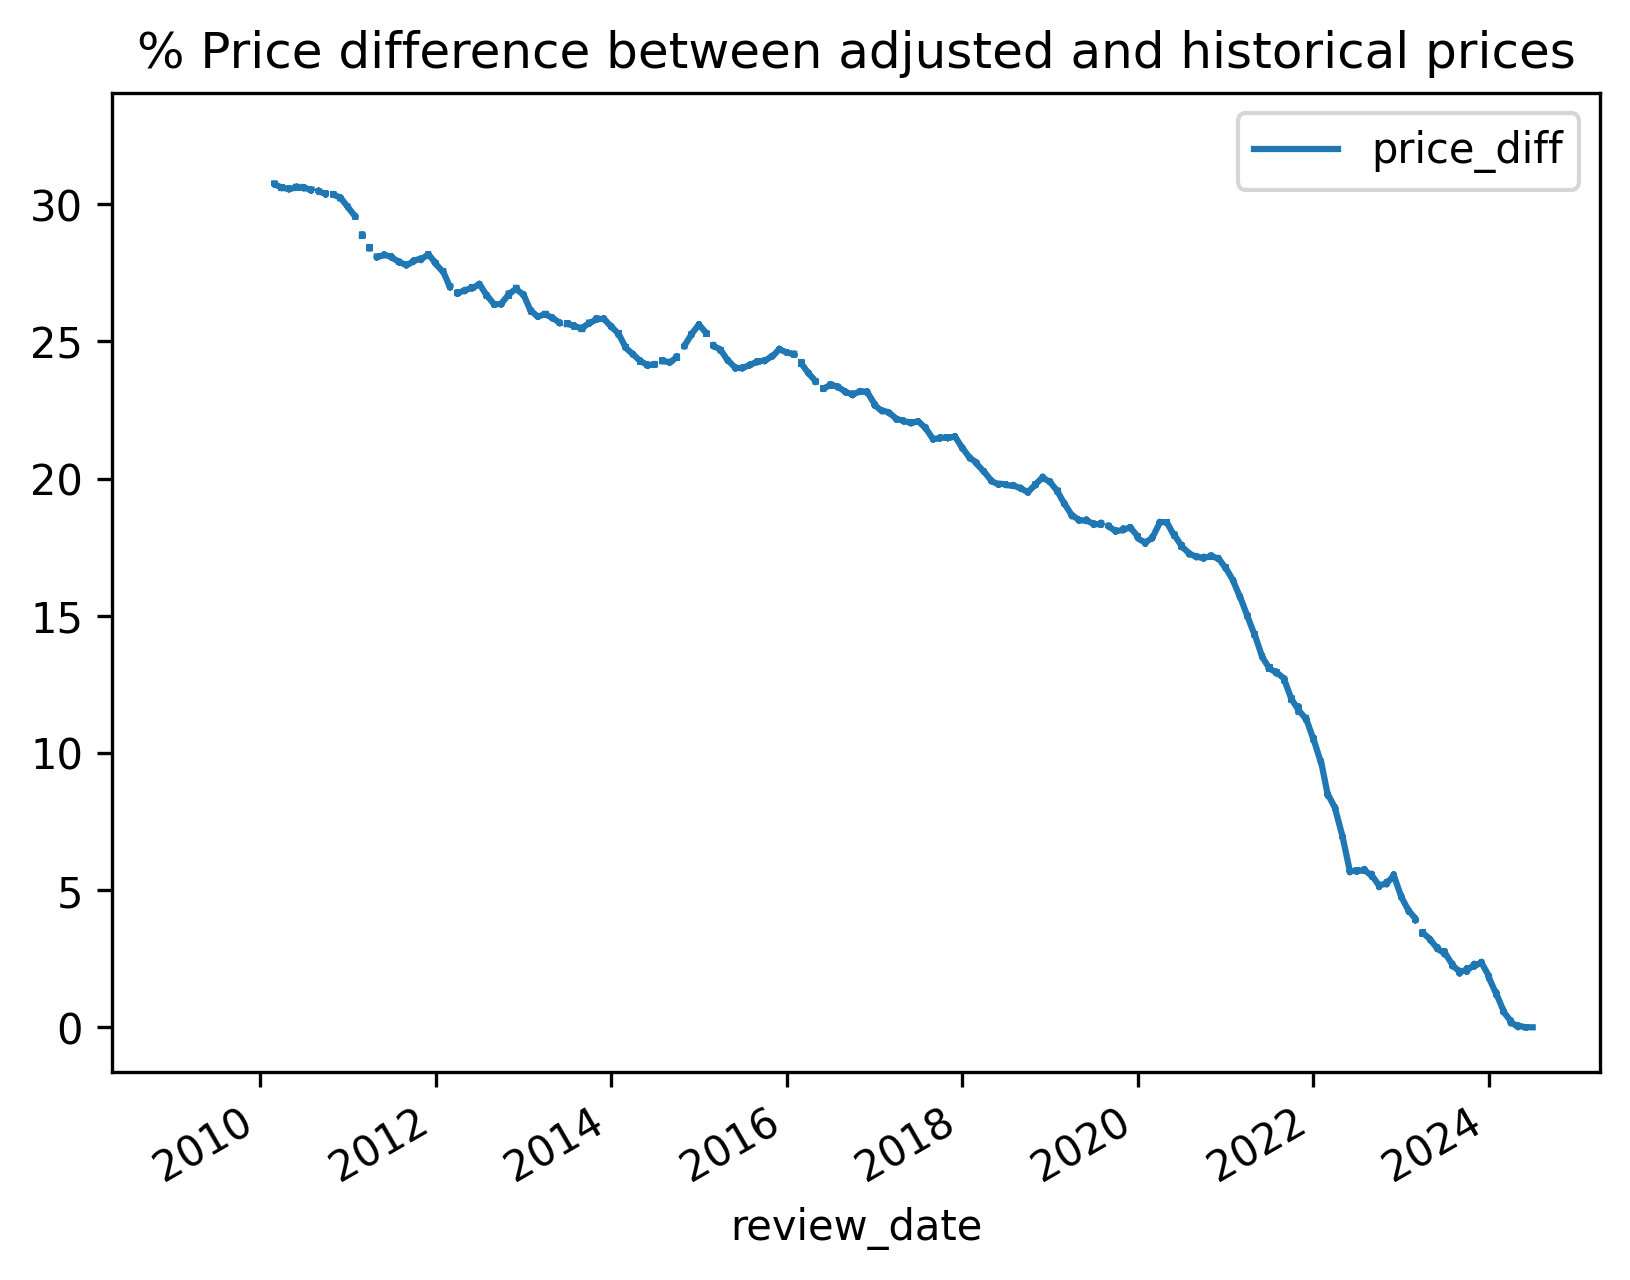

In [11]:
# Plot the price difference between the adjusted and historical prices over time

(
    df.assign(
        price_diff=lambda df_: (df_["price_usd_adj"] - df_["price_usd"])
        / df_["price_usd_adj"]
        * 100
    ).sort_values("review_date")
).plot(
    x="review_date",
    y="price_diff",
    title="% Price difference between adjusted and historical prices",
)

### Create a column for price/lb using adjusted price 

In [12]:
# Create a new column for price per pound
def price_per_lbs(df: pd.DataFrame) -> pd.DataFrame:
    df["price_usd_adj_per_lb"] = np.round(
        df["price_usd_adj"] / df["quantity_in_lbs"], 2
    )
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(price_quantity_split)
    .pipe(clean_currency)
    .pipe(convert_currency)  # Convert to USD with historical exchange rates
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)  # Adjust for inflation
    .pipe(convert_to_lbs)  # Convert quantities to pounds
    .pipe(price_per_lbs)  # Calculate adjusted USD price per pound
)

df.head()

Shape of original DataFrame: (7566, 21)
Shape of price_quantity: (5607, 4)


,rating,roaster,title,blind_assessment,notes,bottom_line,roaster_location,coffee_origin,roast_level,est_price,review_date,aroma,acidity,body,flavor,aftertaste,url,with_milk,agtron_external,agtron_ground,is_espresso,quantity_value,quantity_unit,price_value,price_currency,price_usd,cpi,date,price_usd_adj,quantity_in_lbs,price_usd_adj_per_lb
0,92.0,Red Rooster Coffee Roaster,Ethiopia Sidama Shoye,"Rich, intricate and layered. Lemon zest, roasted cacao nib, violet, mulberry, frankincense in ar...",Produced by family-owned farms that are part of the Shoye Cooperative. This lot was processed by...,"An elegant washed Sidamo cup, both deeply sweet and delicately tart.","Floyd, Virginia","Sidamo (also Sidama) growing region, southern Ethiopia",Medium-Light,$14.49/12 ounces,2016-11-01,9.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-sidama-shoye/,NaN,56.0,80.0,False,12.0,ounces,14.49,USD,14.49,241.353,2016-11-01,18.86,0.75,25.15
1,92.0,El Gran Cafe,Finca Santa Elisa Geisha,"Gently sweet-tart, crisply herbaceous. Baking chocolate, green grape, lemon verbena, fresh-cut o...","Produced by Finca Santa Elisa entirely of the Geisha variety of Arabica, and processed by the tr...","A confident, pretty washed-process Guatemala Geisha enlivened by crisp chocolate and sweet herb ...","Antigua, Guatemala","Acatenango growing region, Guatemala",Medium-Light,$30.00/12 ounces,2023-08-01,8.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/finca-santa-elisa-geisha/,NaN,62.0,78.0,False,12.0,ounces,30.00,USD,30.00,307.026,2023-08-01,30.70,0.75,40.93
2,93.0,Tipico Coffee,Costa Rica Sin Limites Gesha,"Floral-toned, tropical-leaning. Magnolia, guava, green banana, amber, cocoa nib in aroma and cup...","Produced by Jamie Cardenas of Finca Sin Limites, entirely of the Gesha variety of Arabica, and p...","A delicate honey-processed Costa Rica Gesha that evokes the tropics with its fruity profile, and...","Buffalo, New York","West Valley, Costa Rica",Light,$33.00/12 ounces,2024-06-01,9.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/costa-rica-sin-limites-gesha/,NaN,60.0,82.0,False,12.0,ounces,33.00,USD,33.00,314.175,2024-06-01,33.00,0.75,44.00
3,91.0,Roast House,Ride the Edge,"Crisply floral, delicately lively. Complex flowers – lavender, lilac – roasted cacoa nib, tanger...","The coffees in this blend are certified organically grown and Fair Trade, meaning they were purc...",NaN,"Spokane, Washington","Southern Ethiopia; Mexico; northern Sumatra, Indonesia.",Medium,$14.00/16 ounces,2015-07-01,8.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ride-the-edge/,NaN,53.0,67.0,False,16.0,ounces,14.00,USD,14.00,238.654,2015-07-01,18.43,1.00,18.43
4,92.0,Level Ground Trading,Direct Fair Trade Espresso,"Evaluated as espresso. Intrigungly complex, balanced. Dark chocolate, molasses, cedar, narcissus...",Coffees in this blend are all fully wet-processed or “washed” and certified organically grown in...,A solid espresso blend equally pleasing as a straight shot and in milk.,"Victoria, British Columbia, Canada",Africa; South America,Medium-Light,CAD $17.00/16 ounces,2017-11-01,9.0,NaN,8.0,8.0,8.0,https://www.coffeereview.com/review/direct-fair-trade-espresso-2/,9,51.0,73.0,True,16.0,ounces,17.00,CAD,13.21,246.669,2017-11-01,16.83,1.00,16.83


# 4. Coffee Origin Cleaning <a id='coffee_origin_cleaning'></a>
[Back to top](#table_of_contents)

In [13]:
def tweak_countries(countries: set) -> set:
    remove: list = [
        "american samoa",
        "united states minor outlying islands",
        "south sudan",
        "south georgia and the south sandwich islands",
        "british indian ocean territory",
        "congo, the democratic republic of the",
        "taiwan, province of china",
        "guinea",
    ]

    for r in remove:
        try:
            countries.remove(r)
        except ValueError:
            continue
    for c in list(countries):
        c_new: str = c.split(",")[0]
        countries.remove(c)
        countries.add(c_new)

    countries.add("tawain")
    return countries


countries: set = tweak_countries(
    set(unidecode(c.name.lower()) for c in pycountry.countries)
)

In [20]:
def retrieve_countries(element: str, countries: set) -> str:
    countries_found: set = set()
    if pd.isna(element) or element == "":
        return ""
    for c in countries:
        if c in element:
            countries_found.add(c)
    if len(countries_found) == 0:
        return element
    # alphabetically sort the countries found
    countries_found = sorted(countries_found)
    return ";".join(countries_found)


def clean_origin(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(coffee_origin=df.coffee_origin.str.lower())
    df["origin_country"] = df.coffee_origin.apply(
        retrieve_countries, countries=countries
    )
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(price_quantity_split)
    .pipe(clean_currency)
    .pipe(convert_currency)
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)
    .pipe(convert_to_lbs)
    .pipe(price_per_lbs)
    .pipe(clean_origin)
)

Shape of original DataFrame: (7566, 21)
Shape of price_quantity: (5607, 4)


In [19]:
df.origin_country.value_counts()

origin_country
ethiopia                                        1345
colombia                                         696
kenya                                            621
guatemala                                        446
indonesia                                        371
                                                ... 
ethiopia;colombia;thailand                         1
the americas                                       1
ethiopia;tanzania;nicaragua                        1
latin america                                      1
kona growing district, big island of hawai'i       1
Name: count, Length: 508, dtype: int64

# 5. Export processed data <a id='export_data'></a>
[Back to top](#table_of_contents)

In [21]:
FILE_OUT: str = FILE_IN.replace(".csv", "_intermediate.csv")
df.to_csv(DATA_DIR / "intermediate" / FILE_OUT, index=False)

# 6. External Processing <a id='external_processing'></a>
[Back to top](#table_of_contents)

The data exported in the previous step will be further cleaned using [OpenRefine](https://openrefine.org/). This will include cleaning up roaster names, and cleaning up and reconciling roaster and coffee origin locations.

